In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn import metrics

from lightgbm import LGBMRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.base import BaseEstimator, ClassifierMixin
from lightgbm import LGBMClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier

class RegClass(BaseEstimator, ClassifierMixin):
    """Решение задачи регрессии, используя модели классификации"""
    
    #def __init__(self, model=LGBMClassifier, N=5, bins_numb=100):
    def __init__(self, N=5, bins_numb=100):
        """
        Инициализация
        model - модель классификатора
        N - количество бинов, на которые делятся данные на каждом уровне
        bins_nums - итоговое число бинов
        """
        #self.model = model
        self.N = N
        self.bins_numb = bins_numb

        # Массив для хранения индексов новых классов
        self.class_array = {}
        # Массив для пересчёта нового таргета в старый
        self.target_class_arr = {}
        # Массив для обученных классификаторов
        self.model_clf_arr = {}
        
        self.bins_total_borders = 0
        
        
    def borders_no_empty_bins(ser_target, hist):
        """Функция определения количества непустых бинов, 
        в которые попадают значения переданного сегмента 
        таргет-переменной ser_target"""
        
        bins_borders_pairs_list = []
        prev_border = None
        for b in hist:
            if prev_border:
                # Проверка - попадает ли хоть одно значение таргета в рассматриваемый бин
                if b != hist[-1]:
                    # Если текущий бин не последний, то его правая граница исключается
                    if len(ser_target[(ser_target >= prev_border) & (ser_target < b)]) > 0:
                        bins_borders_pairs_list.append([prev_border, b])
                else:
                    # Если текущий бин последний, то его правая граница включается
                    if len(ser_target[(ser_target >= prev_border) & (ser_target <= b)]) > 0:
                        bins_borders_pairs_list.append([prev_border, b])
            prev_border = b
        return bins_borders_pairs_list


    def split_n_bins(self, ser_target, n):
        """Функция деления датафрейма на n примерно равных частей 
        (границы разбивки сдвигаются к ближайшим границам бинов)"""
        
        #digits = ser_target.astype('int8').unique()
        #digits_numb = len(digits)

        # Вычисляем границы непустых бинов в ser_target
        bins_cur_borders = RegClass.borders_no_empty_bins(ser_target, self.bins_total_borders)

        # Количество непустых бинов
        bins_numb = len(bins_cur_borders)

        # Если количество непустых бинов меньше, чем n, уменьшаем значение n до количества непустых бинов
        if bins_numb < n:
            n = int(bins_numb)

        # Возвращаемый массив индексов для каждого бина, на которые разбивается ser_target
        ind_arr = {}

        start_ind = ser_target.index.min()
        last_ind = start_ind

        for i in range(n):
            # Вычисление последнего индекса текущего бина (на основе общего количества записей в ser_target)
            cur_end_1 = start_ind + len(ser_target) // n * (i + 1) - 1
            # Вычисление последнего индекса текущего бина (на основе количества оставщихся непустых бинов)
            if i < (n - 1):
                # Если текущий бин не последний, его правая граница не включается
                cur_end_2 = ser_target[ser_target < bins_cur_borders[-(n - i)][1]].index.max()
            else:
                # Если текущий бин последний, его правая граница включается
                cur_end_2 = ser_target[ser_target <= bins_cur_borders[-(n - i)][1]].index.max()

            # Выбор наименьшего индекса из двух
            cur_end = min(cur_end_1, cur_end_2)

            # Если последний индекс оказался меньше начального, сдвигаем последний до начального (вправо)
            if cur_end < last_ind:
                cur_end = last_ind

            # Определяем правую границу текущего бина
            for b in bins_cur_borders:
                if b[1] > ser_target[cur_end]:
                    cur_target_end_bin = b[1]
                    break

            # Если текущий бин не является последним, то сдвигаем его последний индекс вправо до границы, вычисленной выше
            if i < (n - 1):
                cur_end = ser_target[ser_target < cur_target_end_bin].index.max()
            # Если текущий бин - последний - сдвигаем его последний индекс до последнего индекса ser_target
            else:
                cur_end = ser_target.index.max()

            # Запись полученного списка индексов в возвращаемый массив
            ind_arr[i] = ser_target.loc[last_ind:(cur_end)].index

            last_ind = cur_end + 1
        return ind_arr
    
    
    def save_class(self, ind_arr_new, class_array):
        """Функция вычисления новых лейблов для последующей работы классификаторов
        ind_arr_new - массив с диапазонами индексов, разделённых на бины (функция split_n_bins)
        class_array - внешний массив, хранящий вычисленные новые лейблы таргета для всех индексов датасета
        class_array_cur - возвращаемый массив с новыми лейблами только для текущей части датасета
        """
        class_array_cur = {}
        for i in ind_arr_new:
            for j in ind_arr_new[i]:
                if j in class_array:
                    class_array[j] = class_array[j] + '-' + str(i)
                else:
                    class_array[j] = '0-' + str(i)
                class_array_cur[j] = class_array[j]
        return class_array_cur


    def split_recursion(self, X, y, n, cl):
        """Рекурсивная функция для деления текущего сегменда датафрейма на n бинов и обучения классификаторов
        n = self.N
        cl - лейбл текущего бина, для которого запускается функция split_recursion для дальнейшего деления
        """
        
        # Получение массива индексов для каждого бина после деления
        i_arr = self.split_n_bins(y, n)

        # Вычисление новых лейблов для текущего сегмента данных
        class_array_cur = self.save_class(i_arr, self.class_array)

        # Перебор текущих бинов, определение нового класса текущего бина, запуск текущей функции для дальнейшего деления на бины
        for i in range(len(i_arr)):
            # Сохраняем текущий лейбл бина
            class_cur = cl

            # Проверка правильности вычисленного нового лейбла
            class_new = class_cur + '-' + str(i)
            class_new_2 = class_array_cur[i_arr[i][0]]
            if class_new != class_new_2:
                print(f"Error, class_new = {class_new}, class_new_2 = {class_new_2}")

            # Выделение текущего бина в новый Series
            y_cur = y[i_arr[i]]

            # Если в новом сегменте таргета более одного итогового бина, запускаем текущую функцию снова для дальнейшего деления
            bins_cur_borders = RegClass.borders_no_empty_bins(y_cur, self.bins_total_borders)
            if len(bins_cur_borders) > 1:
                self.split_recursion(X.loc[y_cur.index, :], y_cur, n, class_new)

            # Иначе дополнение массива для пересчёта нового таргета в старый
            else:
                self.target_class_arr[class_new] = (bins_cur_borders[0][0] + bins_cur_borders[0][1]) / 2

        # Создание и обучение классификатора на текущем сегменте данных с новым лэйблом
        #self.model_clf_arr[class_cur] = self.model()
        
        #self.model_clf_arr[class_cur] = LGBMClassifier()
        self.model_clf_arr[class_cur] = XGBClassifier(verbosity = 0)
        #self.model_clf_arr[class_cur] = GradientBoostingClassifier()
        #self.model_clf_arr[class_cur] = CatBoostClassifier()
        #self.model_clf_arr[class_cur] = LogisticRegression()
        
        self.model_clf_arr[class_cur].fit(X, pd.Series(class_array_cur))
    

    def predict_row(self, df_row, cl):
        """Предсказание таргета (старого) для текущего ряда"""
        
        if cl in self.model_clf_arr:
            pred = self.model_clf_arr[cl].predict(df_row.reshape(1, -1))[0]
            class_result = self.predict_row(df_row, pred)
        else:
            return self.target_class_arr[cl]

        return class_result


    def itertuples_func(self, df):
        """Предсказание таргета (старого) для всего датасета"""
        
        return np.array([self.predict_row(np.array(row), '0') for row in df.itertuples(index=False)])
        

    def fit(self, X, y, random_state=None):
        """Обучение модели"""
        
        X = X.reset_index(drop=True)
        y = y.reset_index(drop=True)
        
        y_train_sorted = y.sort_values()
        X_train_scaled_sorted = X.iloc[y_train_sorted.index, :].reset_index(drop=True)
        y_train_sorted = y_train_sorted.reset_index(drop=True)
        
        # Расчёт границ итогового набора бинов
        self.bins_total_borders = np.histogram(y_train_sorted, bins=self.bins_numb)[1]

        # Запуск основной функции, которая заполняет созданные выше массивы
        self.split_recursion(X_train_scaled_sorted, y_train_sorted, self.N, '0')
        
        return self
    

    def predict(self, X):
        """Предиктор"""

        p = self.itertuples_func(X)
        
        return p

In [3]:
# Функция вычисления метрики MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Функция для вычисления всех метрик
def dataframe_metrics(y_test,y_pred):
    stats = [
       metrics.mean_absolute_error(y_test, y_pred),
       np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
       metrics.r2_score(y_test, y_pred),
       mean_absolute_percentage_error(y_test, y_pred)
    ]
    return stats

In [4]:
df = pd.read_csv('./data/AB_NYC_2019_EDA.csv').drop(['Unnamed: 0'], axis=1)

target_name = 'price'

<AxesSubplot:>

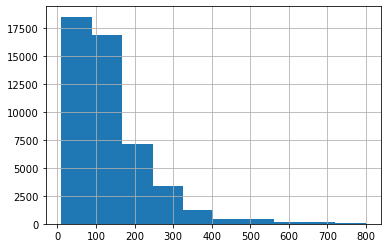

In [5]:
df.price.hist()

<AxesSubplot:>

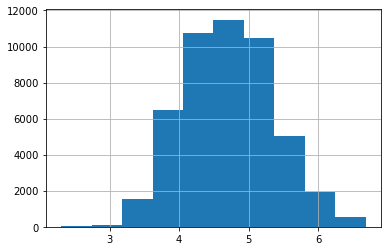

In [6]:
np.log(df.price).hist()

In [8]:
df2 = df.copy()

df2[target_name] = np.log(df[target_name])
#df2 = df

X_train, X_test, y_train, y_test = train_test_split(df2.drop([target_name], axis=1), df2[target_name], test_size=0.3)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [9]:
rc_test = RegClass()

param_grid = {'N': [3, 7, 10, 20, 30], 'bins_numb': [5, 10, 30, 50]}

rc_gscv = GridSearchCV(rc_test, param_grid, cv=5, n_jobs=-1, scoring='r2')

rc_gscv.fit(X_train_scaled, y_train)

rc_gscv.best_params_

{'N': 3, 'bins_numb': 10}

In [10]:
rc_test = RegClass(N=3, bins_numb=10)

rc_test.fit(X_train_scaled, y_train)
#rc_test.fit(X_train_scaled, np.log(y_train))

measured_metrics = pd.DataFrame({"error_type":["MAE", "RMSE", "R2", "MAPE"]})
measured_metrics.set_index("error_type")

measured_metrics["rc_test"] = dataframe_metrics(y_test, rc_test.predict(X_test_scaled))
#measured_metrics["rc_test"] = dataframe_metrics(y_test, np.exp(rc_test.predict(X_test_scaled)))
measured_metrics

,error_type,rc_test
0,MAE,0.325272
1,RMSE,0.434011
2,R2,0.560076
3,MAPE,6.912017


In [11]:
xgb_reg = XGBRegressor(verbosity = 0)

xgb_reg.fit(X_train_scaled, y_train)

measured_metrics["xgb_reg"] = dataframe_metrics(y_test, xgb_reg.predict(X_test_scaled))
measured_metrics

,error_type,rc_test,xgb_reg
0,MAE,0.325272,0.297605
1,RMSE,0.434011,0.397543
2,R2,0.560076,0.630901
3,MAPE,6.912017,6.352953


Проверка стабильности модели

In [12]:
scores = cross_validate(rc_test, X_train_scaled, y_train, cv=5, scoring=('r2', 'neg_mean_squared_error'), return_train_score=True, n_jobs=-1)
print(scores['train_neg_mean_squared_error'])
print(scores['train_r2'])
print(scores['test_neg_mean_squared_error'])
print(scores['test_r2'])

[-0.11661205 -0.11658136 -0.11723696 -0.11888126 -0.1180547 ]
[0.72761585 0.72637    0.725883   0.72205884 0.72295908]
[-0.18642034 -0.18586152 -0.1924652  -0.18605377 -0.18825743]
[0.55954751 0.56922653 0.54709065 0.56202164 0.56341309]


In [13]:
scores_reg = cross_validate(xgb_reg, X_train_scaled, y_train, cv=5, scoring=('r2', 'neg_mean_squared_error'), return_train_score=True, n_jobs=-1)
print(scores_reg['train_neg_mean_squared_error'])
print(scores_reg['train_r2'])
print(scores_reg['test_neg_mean_squared_error'])
print(scores_reg['test_r2'])

[-0.10905305 -0.10710484 -0.10743513 -0.11017578 -0.10577764]
[0.74527229 0.7486125  0.7488011  0.74241202 0.75176986]
[-0.15428652 -0.15369848 -0.15639393 -0.15331693 -0.16074472]
[0.63546959 0.64377118 0.63197361 0.63908554 0.62721769]
